# Download the German model for Stanza

Downloading the German model, which includes pre-trained models and resources necessary for tokenization and sentiment analysis in German language.

In [2]:
import stanza 
import pandas as pd
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
import matplotlib.pyplot as plt

C:\Users\Leonie\anaconda3\envs\test\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#download models models for tokenization and sentiment analysis in the german language
stanza.download('de', processors='tokenize,sentiment')

#Initialize the pipeline for German language with tokenization and sentiment analysis
nlp = stanza.Pipeline(lang='de', processors='tokenize,sentiment')

2024-05-14 16:39:35 INFO: Downloaded file to C:\Users\Leonie\stanza_resources\resources.json
2024-05-14 16:39:35 WARNING: Language de package default expects mwt, which has been added
2024-05-14 16:39:35 INFO: Downloading these customized packages for language: de (German)...
| Processor       | Package      |
----------------------------------
| tokenize        | gsd          |
| mwt             | gsd          |
| sentiment       | sb10k_charlm |
| forward_charlm  | newswiki     |
| pretrain        | conll17      |
| backward_charlm | newswiki     |

2024-05-14 16:39:35 INFO: File exists: C:\Users\Leonie\stanza_resources\de\tokenize\gsd.pt
2024-05-14 16:39:35 INFO: File exists: C:\Users\Leonie\stanza_resources\de\mwt\gsd.pt
2024-05-14 16:39:35 INFO: File exists: C:\Users\Leonie\stanza_resources\de\sentiment\sb10k_charlm.pt
2024-05-14 16:39:35 INFO: File exists: C:\Users\Leonie\stanza_resources\de\forward_charlm\newswiki.pt
2024-05-14 16:39:35 INFO: File exists: C:\Users\Leonie\stanza_

# Import Data

In [4]:
#Read excel
#nrows just for now for testing-delete later
data = pd.read_excel('../data/subset_studium_german.xlsx')

In [5]:
#Only use labeled data or rows that are not empty
data = data[data['Studium_Label'].notnull()]

In [6]:
data.head()

,Unnamed: 0,Studium,Studium_Label,Studium_Comment
0,0,Die Vorlesungszeit war von Anfang September bi...,neutral,"pos:\nVielzahl an Kursen, praxisnäher, Sprachn..."
1,1,Die Pazmany Universität ist sehr klein im Verg...,positive,pos:\nsehr klein was ich schön und angenehm fa...
2,2,Mit der Universität selbst hatten wir wenig zu...,neutral,neg:\nkaum Zeit zu arbeiten\n\npos: alles ist ...
3,3,Da die Vorlesungen wegen der Pandemie online s...,positive,"pos:\nnette Mensa, großes Kursangebot, leichte..."
4,4,Die City University of Hong Kong hat eine groß...,negative,"neg: \nhoher Workload, Bewertung intransparent..."


In [7]:
#Create copy of data for testing different pos/neutr/neg intervals later
data_copies = [data.copy() for _ in range(1, 7)]

In [14]:
#Put all texts from column Studium in list
column = data["Studium"]
texts = column.tolist()

# Model

It iterates through each text, tokenizes it into sentences, and computes the sentiment score for each sentence. We weights longer sentences more by factoring in the word count of each sentence during sentiment score calculation. The sentiment scores are then aggregated to determine the overall sentiment of each text, where longer sentences have a proportionally higher impact on the sentiment calculation. Finally, the counts of each sentiment category—positive, negative, or neutral—are printed.

negative, neutral, and positive, represented by 0, 1, 2 


In [15]:
def getSentiment(neutr_interv, neg_interv, df):
    """
    Calculate sentiment scores for each text and classify them into positive, negative, or neutral labels.

    Parameters:
    - neutr_interv (float): Interval for neutral sentiment.
    - neg_interv (float): Interval for negative sentiment.
    - df (DataFrame): DataFrame containing the texts.

    Returns:
    - None
    """
    total_sentiment = 0
    neg = 0
    pos = 0
    neutr = 0

    # Iterate through all texts
    for i, text in enumerate(df['text']):
        doc = nlp(text)
        text_sentiment = 0
        word_count_all = 0

        # Iterate through all sentences in one text
        for sentence in doc.sentences:
            word_count = len(sentence.words)
            word_count_all += word_count
            # Take longer sentences into consideration and weigh them more
            text_sentiment += (sentence.sentiment * word_count)
    
        total_sentiment = text_sentiment / word_count_all

        # Interval for positive label
        if total_sentiment <= 2 and total_sentiment > neutr_interv:
            pos += 1
            sentiment= "positive"
        # Interval for neutral label
        elif total_sentiment <= neutr_interv and total_sentiment >= neg_interv:
            neutr += 1
            sentiment= "neutral"
        # Interval for negative label
        else:
            neg += 1
            sentiment= "negative"
        # Add sentiment as a new column to the DataFrame
        df.loc[i, 'Sentiment'] = sentiment

    # Print sum 
    print(f"Neg: {neg} Pos: {pos} Neutr: {neutr}")


In [16]:
def saveSentiData(name, data):
    """
    Save the DataFrame as a new Excel file.

    Parameters:
    - name (str): Name of the file without extension.
    - data (DataFrame): DataFrame to be saved.
    """
    filename = f'{name}_studium_with_sentiment.xlsx'
    data.to_excel(filename, index=True)

In [17]:
def readSentiData(name):
    """
    Read the saved sentiment data from an Excel file and preprocess it.

    Parameters:
    - name (str): Name of the file without extension.

    Returns:
    - DataFrame: Preprocessed sentiment data.
    """
    filename = f'{name}_studium_with_sentiment.xlsx'
    data_senti = pd.read_excel(filename)
    data_senti = data_senti[data_senti['Sentiment'].notnull()]
    data_senti = data_senti[data_senti['Studium_Label'].notnull()]
    return data_senti

In [22]:
def adjust_sentiment(sentiment_score, words):
    """
    Adjusts the sentiment score based on the presence of booster or dampener words in the text.

    Parameters:
        sentiment_score (float): The sentiment score to be adjusted.
        words (list): A list of words in the text.

    Returns:
        float: The adjusted sentiment score.
    """
    # Check if a booster or dampener word is present in the sentence
    has_booster = any(word.lower() in booster for word in words)
    has_dampener = any(word.lower() in dampner for word in words)

    # If a booster word is present, multiply the sentiment score by the corresponding value
    if has_booster:
        booster_word = next((word for word in words if word.lower() in booster), None)
        sentiment_score *= max(booster.values())

    # If a dampener word is present, multiply the sentiment score by the corresponding value
    if has_dampener:
        sentiment_score *= min(dampner.values())

    return sentiment_score

In [23]:
def getSentimentBoostDamp(neutr_interv,neg_interv, df):
    """
    Calculate sentiment scores for texts and classify them into sentiment categories.

    Parameters:
    - neutr_interv (float): Upper bound of the neutral sentiment interval.
    - neg_interv (float): Lower bound of the negative sentiment interval.
    - df (DataFrame): DataFrame containing the texts to analyze.

    Returns:
    None
    """
    total_sentiment = 0
    neg = 0
    pos = 0
    neutr = 0
    for i, text in enumerate(texts):
        doc = nlp(text)
        total_sentiment = 0
        word_count_all = 0
        
        for sentence in doc.sentences:
            word_count = len(sentence.words)
            word_count_all += word_count
        
            sentence_sentiment = sentence.sentiment
            words_in_sentence = [word.text.lower() for word in sentence.words]
            sentiment_score = adjust_sentiment(sentence_sentiment, words_in_sentence) * word_count     
            
            total_sentiment += sentiment_score
            
        # Calculate overall sentiment based on adjusted scores
        average_sentiment = total_sentiment / word_count_all
        
        # Classify sentiment category based on adjusted scores
        if neutr_interv < average_sentiment <= 2.0:
            sentiment = "positive"
            pos+=1
        elif neg_interv <= average_sentiment <= neutr_interv:
            sentiment = "neutral"
            neutr+=1
        else:
            sentiment = "negative"
            neg+=1
        
        df.loc[i, 'Sentiment'] = sentiment
        #print(average_sentiment)
        #print sum 
    print(f"Neg: {neg} Pos: {pos} Neutr: {neutr}")


## Evaluation 

In [18]:
def calculateMatch(df):
    """
    Calculate the number of matches between 'Studium_Label' and 'Sentiment' columns in the DataFrame.

    Parameters:
    - df (DataFrame): DataFrame containing sentiment labels and predictions.

    Returns:
    - int: Number of matches.
    """
    match_count = (df['Studium_Label'] == df['Sentiment']).sum()
    return match_count


In [19]:
def evaluation(data_senti):
    """
    Evaluate sentiment classification performance using confusion matrix, F1 score, and classification report.

    Parameters:
    - data_senti (DataFrame): DataFrame containing sentiment labels and predictions.

    Returns:
    - None
    """

    # Convert columns to string type
    data_senti['Studium_Label'] = data_senti['Studium_Label'].astype(str)
    data_senti['Sentiment'] = data_senti['Sentiment'].astype(str)
    
    # Compute confusion matrix
    confusion_mat = confusion_matrix(data_senti['Studium_Label'], data_senti['Sentiment'], labels=['positive', 'negative', 'neutral'])

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['positive', 'negative', 'neutral'])
    disp.plot()
    plt.show()
    
    # Compute and print F1 score
    print(f1_score(data_senti['Studium_Label'], data_senti['Sentiment'], labels=['positive', 'negative', 'neutral'], average='micro'))
    
    # Print classification report
    print(classification_report(
        data_senti['Studium_Label'],
        data_senti['Sentiment'],
        output_dict=False,
        target_names=['positive', 'negative', 'neutral']
    ))

## Stanza without Dampener and Booster

### Applying Model

Model tested on different intevals:

intervals for damp/boost run
first interval:
neutr_interv=1.3
neg_interv=0.8
-->0.4387

neutr_interv=1.3
neg_interv=0.9
--> 0.4226
____________
neutr_interv=1.4
neg_interv=0.9
--> 0.40 (worse)
-->postive interval shouldnt be that small
____________
neutr_interv=1.3
neg_interv=0.95
--> 0.4226 --> same accuracy as 1.3/0.9, but more positives ranked as negative
--> neg_interv of 0.9 is better
____________
neutr_interv=1.25
neg_interv=0.9
--> 0.4371
____________
neutr_interv=1.25
neg_interv=0.85
--> 0.4451 --> F1 of negatives in contrast to 1.3/0.8 is sligtly worse (0.03)
--> BEST 
____________
neutr_interv=1.3
neg_interv=0.85
--> 0.4306
____________
neutr_interv=1.2
neg_interv=0.85
--> 0.4241

In [25]:
#Best interval
neutr_interv=1.25
neg_interv=0.85

In [27]:
getSentiment(neutr_interv, neg_interv, data_copies[0]) 
name="data2"
saveSentiData(name, data_copies[0])

Neg: 41 Pos: 651 Neutr: 324


In [28]:
data_senti=readSentiData(name)
data_senti.head()

,Unnamed: 0.1,Unnamed: 0,Studium,Studium_Label,Studium_Comment,Sentiment
0,0,0.0,Die Vorlesungszeit war von Anfang September bi...,neutral,"pos:\nVielzahl an Kursen, praxisnäher, Sprachn...",positive
1,1,1.0,Die Pazmany Universität ist sehr klein im Verg...,positive,pos:\nsehr klein was ich schön und angenehm fa...,neutral
2,2,2.0,Mit der Universität selbst hatten wir wenig zu...,neutral,neg:\nkaum Zeit zu arbeiten\n\npos: alles ist ...,positive
3,3,3.0,Da die Vorlesungen wegen der Pandemie online s...,positive,"pos:\nnette Mensa, großes Kursangebot, leichte...",positive
4,4,4.0,Die City University of Hong Kong hat eine groß...,negative,"neg: \nhoher Workload, Bewertung intransparent...",positive


### Applying Evaluation

447


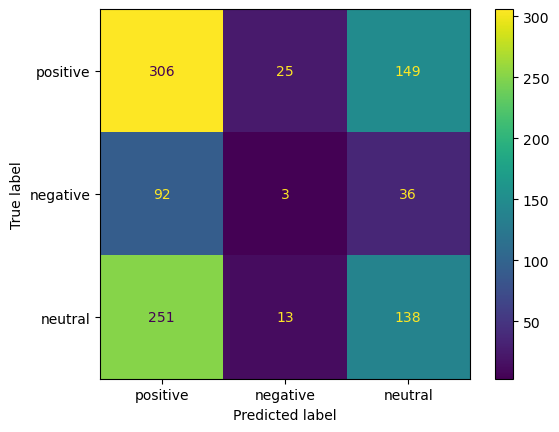

0.4412635735439289
              precision    recall  f1-score   support

    positive       0.07      0.02      0.03       131
    negative       0.43      0.34      0.38       402
     neutral       0.47      0.64      0.54       480

    accuracy                           0.44      1013
   macro avg       0.32      0.33      0.32      1013
weighted avg       0.40      0.44      0.41      1013



In [29]:
print(calculateMatch(data_senti))
evaluation(data_senti)

## Stanza with Dampener and Booster - Wordlist 1
### Applying Model


   1.8/0.1
   -->0.395
____________________
   1.7/0.2
   -->0.405
____________________
   1.5/0.5
   --> 0.415
____________________
   1.4/0.6
   --> 0.423
____________________
   1.4/0.7
   --> 0.424
____________________
   1.5/0.7
   --> 0.424
____________________
   1.6/0.7
   -->0.413
   

In [20]:
# Read the Excel file with boosters and dampeners into a DataFrame 
df = pd.read_excel('../data/Booster_Dampner_stanza.xlsx') #Older File - less words

# Initialize dictionaries for booster and dampner
booster = {}
dampner = {}

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    booster[row['Booster']] = 1.5  # Assigning a score for each booster
    dampner[row['Dampener']] = 0.7  # Assigning a score for each dampner


In [21]:
# Count frequency of booster and dampener words
booster_counts = Counter(booster)
dampner_counts = Counter(dampner)

In [27]:
#intervals for damp/boost run
neutr_interv=1.25
neg_interv=0.8
getSentimentBoostDamp(neutr_interv, neg_interv, data_copies[1])
name="data3"
saveSentiData(name, data_copies[1])
data_senti_boost=readSentiData(name)
data_senti_boost.head()

Neg: 62 Pos: 718 Neutr: 236


,Unnamed: 0.1,Unnamed: 0,Studium,Studium_Label,Studium_Comment,Sentiment
0,0,0.0,Die Vorlesungszeit war von Anfang September bi...,neutral,"pos:\nVielzahl an Kursen, praxisnäher, Sprachn...",positive
1,1,1.0,Die Pazmany Universität ist sehr klein im Verg...,positive,pos:\nsehr klein was ich schön und angenehm fa...,neutral
2,2,2.0,Mit der Universität selbst hatten wir wenig zu...,neutral,neg:\nkaum Zeit zu arbeiten\n\npos: alles ist ...,positive
3,3,3.0,Da die Vorlesungen wegen der Pandemie online s...,positive,"pos:\nnette Mensa, großes Kursangebot, leichte...",negative
4,4,4.0,Die City University of Hong Kong hat eine groß...,negative,"neg: \nhoher Workload, Bewertung intransparent...",positive


### Evaluation

In [25]:
print(calculateMatch(data_senti_boost))

436


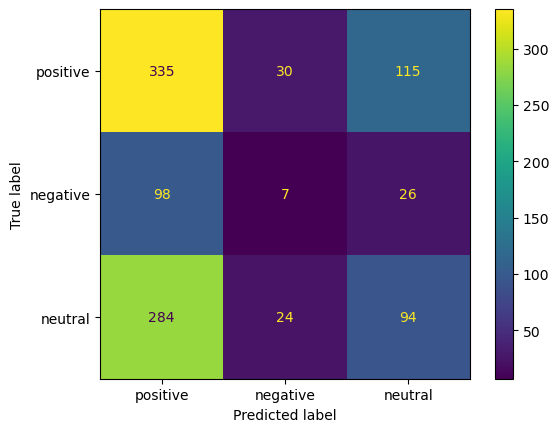

0.43040473840078974
              precision    recall  f1-score   support

    positive       0.11      0.05      0.07       131
    negative       0.40      0.23      0.30       402
     neutral       0.47      0.70      0.56       480

    accuracy                           0.43      1013
   macro avg       0.33      0.33      0.31      1013
weighted avg       0.39      0.43      0.39      1013



In [26]:
evaluation(data_senti_boost)

## Dampener and Booster - Wordlist 2
### Applying Model and Evaluation


  1.8/0.1 (und 1.5 / 0.1)
  --> 0.4000
____________________
  1.7/0.2 
  --> 0.405
____________________
  1.4/0.6
  --> 0.42903
____________________
  1.4/0.7
  --> 0.42096
____________________
  1.9/0.7
  --> 0.39193
___________________
   1.5 / 0.3 
   --> 0.412903
____________________
   1.5 / 0.2
   --> 0.40967620
weighted avg       0.40      0.31      0.31       620


   0.29       620
weighted avg       0.38      0.39      0.37       620

Neg: 37 Pos: 628 Neutr: 351
Border: 1.4 / 0.6
447


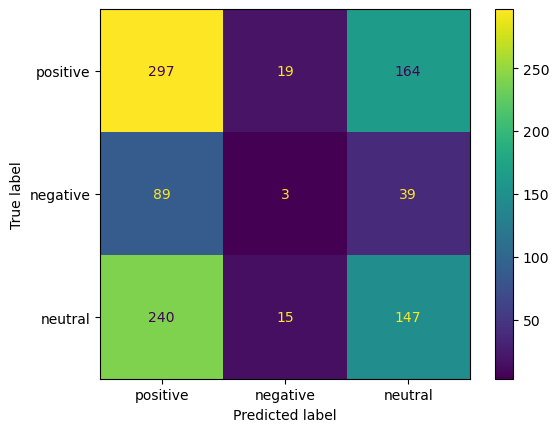

0.4412635735439289
              precision    recall  f1-score   support

    positive       0.08      0.02      0.04       131
    negative       0.42      0.37      0.39       402
     neutral       0.47      0.62      0.54       480

    accuracy                           0.44      1013
   macro avg       0.33      0.34      0.32      1013
weighted avg       0.40      0.44      0.41      1013



In [30]:
value1 = 1.4
value2 = 0.6

# Read the Excel file into a DataFrame
df = pd.read_excel('../data/Booster_Dampner_stanza_oneWord.xlsx') #newer list with more words

# Initialize dictionaries for booster and dampner
booster = {}
dampner = {}

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    booster[row['Booster']] = value1  # Assigning a score for each booster
    dampner[row['Dampener']] = value2  # Assigning a score for each dampner

#print("Booster Dictionary:")
#print(booster)
#print("\nDampner Dictionary:")
#print(dampner)
    
# Count frequency of booster and dampener words
booster_counts = Counter(booster)
dampner_counts = Counter(dampner)

#intervals for damp/boost run
neutr_interv=1.25
neg_interv=0.8

getSentimentBoostDamp(neutr_interv, neg_interv, data_copies[2])
name="data4"
saveSentiData(name, data_copies[2])
data_senti_boost=readSentiData(name)
data_senti_boost.head()

## Evaluation - Booster/Dampner
print(f"Border: {value1} / {value2}")
print(calculateMatch(data_senti_boost))
evaluation(data_senti_boost)